In [1]:
%load_ext autoreload
%autoreload 2
%cd /home/xux/Desktop/Enzyme_design/Savi_design/Savinase-engineering

/home/xux/Desktop/Enzyme_design/Savi_design/Savinase-engineering


# Evaluate model using train/test dataset

In [4]:
import pandas as pd
from popscorer.fitness.ev_onehot import EVOnehotFitness
from easydict import EasyDict as edict
config = {
    'seq_len': 275,
    'predictor': {'data_path': 'data/round1/dry-lab/activity/',},
    'transform': {'trans_type': 'sigmoid', 'low': 1.0, 'high': 10.0},
    'min_val': 64,
}
config = edict(config)

def get_raw_activity_score(aa_seqs):
    score, raw_score = EVOnehotFitness(config)(aa_seqs)
    return raw_score

## Scatter plot of training & testing datasets

In [5]:
# load train & test dataset
data_path = 'data/round1/dry-lab/activity'

data_df = pd.read_csv(f'{data_path}/data.csv', index_col='Unnamed: 0')
df_test = pd.read_csv(f'{data_path}/data_test.csv', index_col='Unnamed: 0.1')

df_train = data_df.drop(df_test.index)
print(df_train.columns)
print(len(data_df), len(df_test), len(df_train), )

df_train['pred_fitness'] = get_raw_activity_score(df_train.seq)
df_test['pred_fitness'] = get_raw_activity_score(df_test.seq)

print(df_train.pred_fitness.min(), df_train.pred_fitness.max(), df_test.pred_fitness.min(), df_test.pred_fitness.max())

Index(['Mutations', 'Score', 'kcat/Km(s-1 mM-1)', '(U/min*mg)', 'Temp (Â°C)',
       'Substrate (AAPF, Casein)', 'Ref', 'Source', 'Paper', 'seq',
       'log_fitness'],
      dtype='object')
150 30 120


/home/xux/miniconda3/envs/prot-gen-env/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.3.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
2025-09-28 22:24:52.884 | DEBUG    | popscorer.fitness.ev_onehot_pred.predictor:load_model:57 - Ridge regression model loaded from path data/round1/dry-lab/activity/ridge_model.pkl
/home/xux/miniconda3/envs/prot-gen-env/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.3.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.w

-8.535624534806985 0.5853915662185472 -11.01617327615503 0.8250669337406009


Test Spearman's rho: 0.718, p=0.000


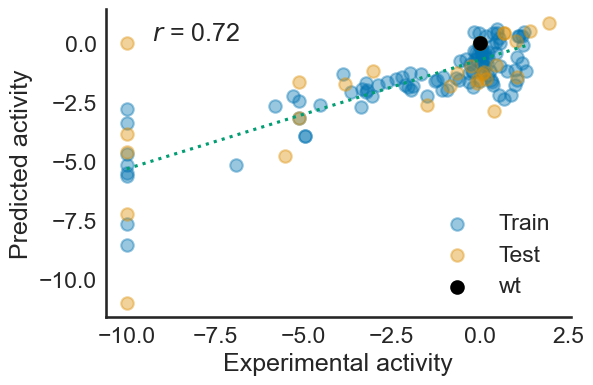

In [6]:
import numpy as np
from utils import plot_style_utils
from scipy import stats

plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax()
plot_style_utils.prettify_ax(ax)

ax.scatter(df_train.log_fitness, df_train.pred_fitness, alpha=0.4, label='Train', color=plot_style_utils.CAT_PALETTE[0])
ax.scatter(df_test.log_fitness, df_test.pred_fitness, alpha=0.4, label='Test', color=plot_style_utils.CAT_PALETTE[1])
ax.scatter([0.0], [-0.007327], alpha=1.0, label='wt', color='black')

train_fit = np.polyfit(df_train.log_fitness, df_train.pred_fitness, 1)
x = np.sort(df_train.log_fitness)
ax.plot(x, train_fit[0] * x + train_fit[1], linestyle=':', color=plot_style_utils.CAT_PALETTE[2])

spearman = stats.spearmanr(df_test.log_fitness, df_test.pred_fitness)

print(f"Test Spearman's rho: {spearman[0]:.3f}, p={spearman[1]:.3f}")
ax.text(0.1, 0.9, "$\it{r}$"+f" = {spearman[0]:.2f}", transform=ax.transAxes)

ax.set_xlabel('Experimental activity')
ax.set_ylabel('Predicted activity')

ax.legend(loc='lower right', frameon=False)

plot_style_utils.save_for_pub(fig=fig, path='figures/round1/eval_act_model')